In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
import analysis2 as a2
reload(a2)
from IPython.display import display, HTML

from flutype.utils import django_setup
from flutype.models import Spot, RawSpotCollection
import preprocessing as pre
#from preprocessing import mean_on_analyte_batch, 
import seaborn as sns
from itertools import combinations
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import matplotlib.cm as cm
import preprocessing as pre


****************************************
RUNNING IN DEVELOP
****************************************


In [2]:
reload(pre)
reload(a2)

<module 'analysis2' from '/home/janekg89/Develop/Pycharm_Projects/flutype_analysis_web/analysis2.py'>

In [5]:
studies = ["microarray_2018_02_18"]
#viruses = ['A/Aichi/2/68(H3N2)-X31-2018-04-13','A/California/7/2009(H1N1)-2018-04-13','A/Hong Kong/4801/2014(H3N2)-2018-04-13','A/Brisbane/10/2007(H3N2)-2018-04-13','A/Brisbaine/59/2007(H1N1)-2018-04-13']
#viruses = ['A/California/7/2009(H1N1)-2018-03-20','A/Panama/2007/1999(H3N2)-2017']
#viruses = ['A/Panama/2007/1999(H3N2)-2017']
from django.db.models import Q

spots_dj = Spot.objects.filter(raw_spot__raw_spot_collection__studies__sid__in=studies)
spots_before = spots_dj.filter(spot_collection__sid = "before")
spots_quant = spots_dj.filter(spot_collection__sid = "quant1")


#cs = ["2018_01_24_slide_21","2018_01_24_slide_22","2018_01_24_slide_23"]
#spots_dj =  spots_quant.filter(raw_spot__raw_spot_collection__sid__in=cs)
#spots_dj = spots_quant.filter(raw_spot__lig_mob_batch__sid__in = viruses)
#print(len(spots_quant))
#spots_dj = spots_dj.filter(Q(circle_quality__gte = 0.3) |Q(raw_spot__lig_fix_batch__sid = None) )
print(len(spots_quant))

data = a2.Data(spots_dj=spots_quant).outlier_filtering()
print(len(data.spots_pd))


20520
20520
19230


In [6]:
def spot_quality_collection(this_data):
    all_collections = this_data.spots_pd.Collection.dropna().unique()
    frames=[]
    for i in np.linspace(0.001,0.8,30):
        for c in all_collections:
            spots_dj = Spot.objects.filter(spot_collection__sid = "quant1")
            spots_dj = spots_dj.filter(raw_spot__raw_spot_collection__sid__in=[c])
            max_spots = len(spots_dj)
            spots_dj = spots_dj.filter(circle_quality__gte = i)
            frames.append(pd.Series(data=[c,i,len(spots_dj)], index=["Collection","Circle Quality","Number"]))
    d_circ = pd.concat(frames,axis=1).T
    d_circ.Number = d_circ.Number.astype(int)/ max_spots
    spot_amount = pd.pivot_table(d_circ,values=["Number"],columns=["Collection"],index=["Circle Quality"])
    return  spot_amount[list(spot_amount.iloc[15].sort_values(ascending=False).index)]

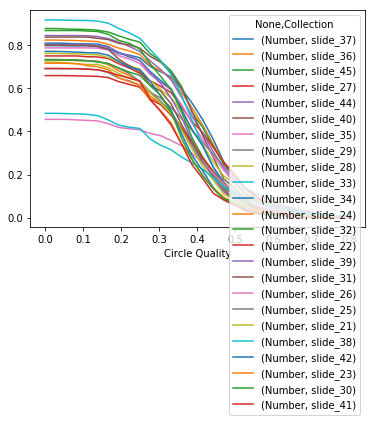

In [7]:
spot_quality_collection(data).plot()

In [523]:
frames = {}
for peptide, d_pep in data.spots_pd.groupby(["Ligand Batch","Analyte Batch"]):
    
    x_mean=  d_pep["Intensity"].mean()
    df =  d_pep.copy()
    df["Intensity_norm"] = ( d_pep["Intensity"]- d_pep["Intensity"].mean())/ d_pep["Intensity"].mean()
    frames[peptide]=df
spots_new = pd.concat(frames)

In [524]:
spots_new

Ligand Batch  \
Empty    A/Aichi/2/68(H3N2)-X31-2017-05-02    361         Empty   
                                              364         Empty   
                                              365         Empty   
                                              367         Empty   
                                              368         Empty   
                                              470         Empty   
                                              471         Empty   
                                              518         Empty   
                                              519         Empty   
                                              520         Empty   
                                              521         Empty   
                                              522         Empty   
                                              523         Empty   
                                              524         Empty   
                                              525         Empty   
                                              526         Empty   
                                              527         Empty   
                                              528         Empty   
                                              529         Empty   
                                              530         Empty   
                                              531         Empty   
                                              532         Empty   
                                              534         Empty   
                                              535         Empty   
                                              536         Empty   
                                              636         Empty   
                                              637         Empty   
                                              638         Empty   
                                              639         Empty   
                                              640         Empty   
...                                                         ...   
P061-0.5 A/Panama/2007/1999(H3N2)-2017        953      P061-0.5   
                                              986      P061-0.5   
                                              1041     P061-0.5   
P061-1   A/Aichi/2/68(H3N2)-X31-2017-05-02    376        P061-1   
                                              409        P061-1   
                                              442        P061-1   
                                              489        P061-1   
                                              542        P061-1   
                                              575        P061-1   
                                              608        P061-1   
                                              662        P061-1   
                                              682        P061-1   
         A/California/7/2009(H1N1)-2018-03-20 16         P061-1   
                                              49         P061-1   
                                              82         P061-1   
                                              136        P061-1   
                                              169        P061-1   
                                              202        P061-1   
                                              256        P061-1   
                                              289        P061-1   
                                              322        P061-1   
         A/Panama/2007/1999(H3N2)-2017        736        P061-1   
                                              769        P061-1   
                                              802        P061-1   
                                              834        P061-1   
                                              867        P061-1   
                                              900        P061-1   
                                              954        P061-1   
                               

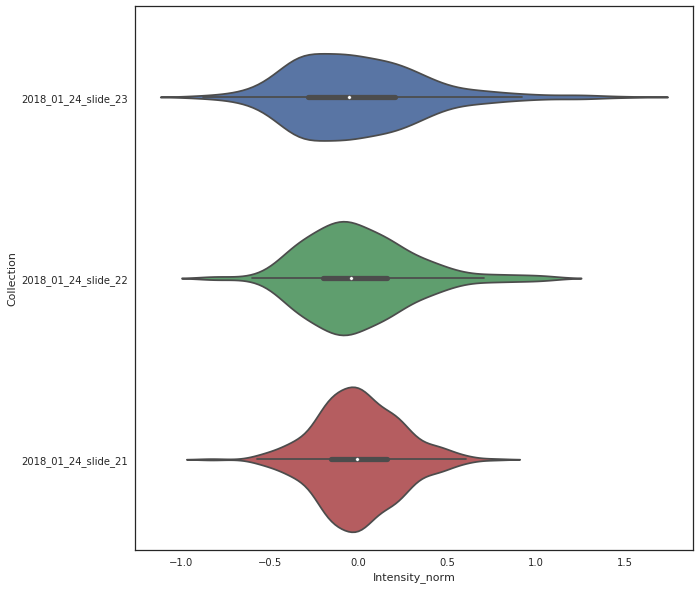

In [525]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.violinplot(data=spots_new, y="Collection", x="Intensity_norm",ax=ax)

In [526]:
mean_collection = pre.mean_on_collection(data.spots_pd)


In [527]:
mean_on_ana = pre.mean_on_analyte_batch(data.spots_pd)


In [528]:
ma = mean_on_ana.groupby(["Analyte Batch"]).mean()["Intensity_rsd"]
ma

Analyte Batch
A/Aichi/2/68(H3N2)-X31-2017-05-02       0.364997
A/California/7/2009(H1N1)-2018-03-20    0.289621
A/Panama/2007/1999(H3N2)-2017           0.227951
Name: Intensity_rsd, dtype: float64

In [529]:
mc = mean_collection.groupby(["Analyte Batch"]).mean()["Intensity_rsd"]
mc


Analyte Batch
A/Aichi/2/68(H3N2)-X31-2017-05-02       0.364997
A/California/7/2009(H1N1)-2018-03-20    0.289621
A/Panama/2007/1999(H3N2)-2017           0.227951
Name: Intensity_rsd, dtype: float64

In [530]:
mean_ligand_col = mean_collection.groupby(["Ligand Batch"]).mean()#.sort_values(by="Intensity")
mean_ligand_ana = mean_on_ana.groupby(["Ligand","Ligand Batch"]).mean()#.sort_values(by="Intensity")


In [531]:
mean_ligand_ana

Ligand Batch Concentration  Analyte Batch Concentraion  \
Ligand Ligand Batch                                                           
LF     LF-0.25                             0.25                         NaN   
       LF-0.5                              0.50                         NaN   
       LF-1                                1.00                         NaN   
P001   P001-0.25                           0.25                         NaN   
       P001-0.5                            0.50                         NaN   
       P001-1                              1.00                         NaN   
P010   P010-0.25                           0.25                         NaN   
       P010-0.5                            0.50                         NaN   
       P010-1                              1.00                         NaN   
P011   P011-0.25                           0.25                         NaN   
       P011-0.5                            0.50                         NaN   
       P011-1                              1.00                         NaN   
P012   P012-0.25                           0.25                         NaN   
       P012-0.5                            0.50                         NaN   
       P012-1                              1.00                         NaN   
P013   P013-0.25                           0.25                         NaN   
       P013-0.5                            0.50                         NaN   
       P013-1                              1.00                         NaN   
P014   P014-0.25                           0.25                         NaN   
       P014-0.5                            0.50                         NaN   
       P014-1                              1.00                         NaN   
P049   P049-0.25                           0.25                         NaN   
       P049-0.5                            0.50                         NaN   
       P049-1                              1.00                         NaN   
P050   P050-0.25                           0.25                         NaN   
       P050-0.5                            0.50                         NaN   
       P050-1                              1.00                         NaN   
P052   P052-0.25                           0.25                         NaN   
       P052-0.5                            0.50                         NaN   
       P052-1                              1.00                         NaN   
P061   P061-0.25                           0.25                         NaN   
       P061-0.5                            0.50                         NaN   
       P061-1                              1.00                         NaN   

                       Intensity          Std  Circle Quality        Row  \
Ligand Ligand Batch                                                        
LF     LF-0.25        518.899701   552.682623        0.118661  19.375000   
       LF-0.5         524.329565   880.414248        0.083829  20.839286   
       LF-1           581.575212   671.320656        0.099595  20.000000   
P001   P001-0.25      539.075167   883.823615        0.385645  18.180556   
       P001-0.5       649.231590   700.535988        0.486863  17.361111   
       P001-1         929.113775   988.788734        0.466208  17.847222   
P010   P010-0.25      801.188571  1228.361533        0.424978  16.375000   
       P010-0.5      1175.443485  1202.497096        0.381056  17.000000   
       P010-1        1938.327181  1920.096067        0.303661  16.375000   
P011   P011-0.25      693.083644  1037.289095        0.422583  17.333333   
       P011-0.5      1086.182242  1074.229576        0.447056  16.847222   
       P011-1        2040.824560  1926.165230        0.457649  15.089286   
P012   P012-0.25      543.600472   910.192782        0.191027  18.319444   
       P012-0.5       604.381306   616.929799        0.294068  17.666667   
       P012-1        1207.213904  1376.

In [532]:
import numpy as np
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
print (__version__) # requires version >= 1.9.0

#Always run this the command before at the start of notebook
init_notebook_mode(connected=True)
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=mean_ligand_col["Intensity"],
    y=mean_ligand_col["Intensity_rsd"],
    #z=test_data[:,2],
    text = mean_ligand_col.index,
    mode='markers+text',
    hoverinfo='text',
    textposition='bottom',
    #hoverlabel=dict(bgcolor=list(colors)),
    marker=dict(
        size=7,
        #color=colors,                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.99)
)
trace2 = go.Scatter(
    x=mean_ligand_col["Intensity_rsd"],
    y=mean_ligand_ana["Intensity_rsd"]-mean_ligand_col["Intensity_rsd"],
    #z=test_data[:,2],
    text = mean_ligand_ana.index,
    hoverinfo='text',
    textposition='bottom',
    #hoverlabel=dict(bgcolor=list(colors)),
    marker=dict(
        size=7,
        color="r",                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.99)
)

this = [trace1]
layout = go.Layout(
    #scene=dict(
    #    xaxis = dict(showspikes=False),
    #    yaxis = dict(showspikes=False),
    #    zaxis = dict(showspikes=False),

        

     #   )
    )
fig = go.Figure(data=this, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')
#plt.scatter(mean_ligand["Intensity"],mean_ligand["Intensity_rsd"])
#plt.show()

2.6.0


In [533]:
mc

Analyte Batch
A/Aichi/2/68(H3N2)-X31-2017-05-02       0.364997
A/California/7/2009(H1N1)-2018-03-20    0.289621
A/Panama/2007/1999(H3N2)-2017           0.227951
Name: Intensity_rsd, dtype: float64

In [534]:
ma

Analyte Batch
A/Aichi/2/68(H3N2)-X31-2017-05-02       0.364997
A/California/7/2009(H1N1)-2018-03-20    0.289621
A/Panama/2007/1999(H3N2)-2017           0.227951
Name: Intensity_rsd, dtype: float64

In [535]:
#plt.scatter(mc["Intensity"],mc["Intensity_rsd"])
#plt.show()

In [536]:
1-mc/ma

Analyte Batch
A/Aichi/2/68(H3N2)-X31-2017-05-02       0.0
A/California/7/2009(H1N1)-2018-03-20    0.0
A/Panama/2007/1999(H3N2)-2017           0.0
Name: Intensity_rsd, dtype: float64

In [537]:
#df_new = data.subset_ligand_batches(["LF-0.0001","LF-0.001","LF-0.01","LF-0.05","LF-0.1","LF-0.5","Empty", "Nenad"])


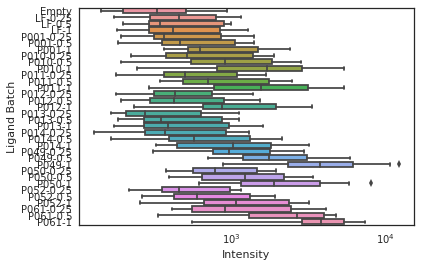

In [538]:
sns.boxplot(data=data.spots_pd, x="Intensity", y="Ligand Batch")
plt.xscale("log")

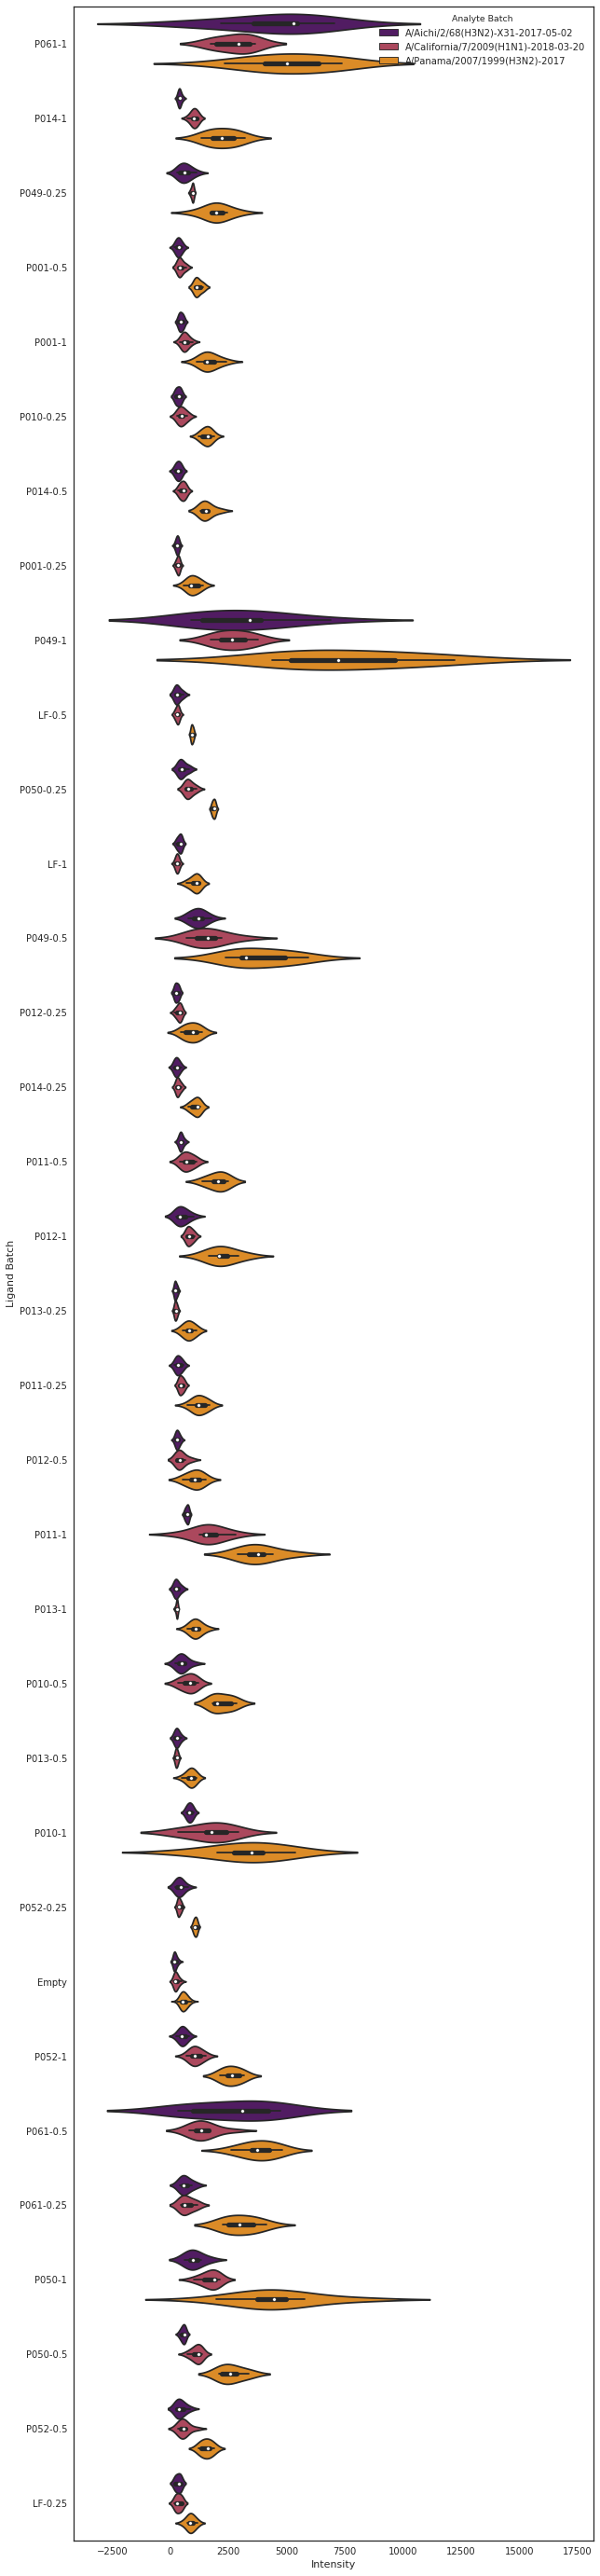

In [552]:
d = data.outlier_filtering()
#d = d.subset_ligand_batches(["P076"])
fig ,ax = plt.subplots(figsize=(10,50))

ax = sns.violinplot(hue="Analyte Batch",
                    x="Intensity",
                    bw=.9, 
                    y="Ligand Batch",
                    scale="width", 
                    data=d.spots_pd.sort_values(by="Analyte Batch"),
                    #split=True,
                    color="white",
                    palette=sns.color_palette("inferno",n_colors=3),


                    )
'''
ax = sns.swarmplot(hue="Analyte Batch",
                   y="Ligand Batch", 
                   x="Intensity",
                   palette=sns.color_palette("inferno",n_colors=3),
                   #color="white",
                   data=d.spots_pd.sort_values(by="Analyte Batch"),
                   size=8,
                   #split=True,
                   edgecolor="grey",
                   linewidth=0.1,)
'''

        
#ax.legend_.remove()
plt.show()

In [553]:
frames = {}

for name, d in data.spots_pd.groupby("Collection"):
    mask = d["Ligand Batch"] == "LF-1"
    d_LF = d[mask]["Intensity"].mean()
    mask = d["Ligand Batch"] == "Empty"
    d_Empty = d[mask]["Intensity"].mean()
    x = d.copy()
    x["Intensity"] = (d["Intensity"]/d_Empty)#/(d_LF+ d_Empty)
    frames[name] = x
spots_pd_norm = pd.concat(frames)



In [554]:
data_norm=a2.Data(spots_pd=spots_pd_norm)

In [555]:

peptide_c_signif = data_norm.ligand_batch_significance()



In [556]:
peptide_c_signif

,Ligand Batch,Ligand,Ligand Batch Concentration,Analyte Batches,Significance,V1_I,V2_I,V1_Err,V2_Err,V1_Count,V2_Count
0,P052-0.5,P052,0.5,"(A/Aichi/2/68(H3N2)-X31-2017-05-02, A/Californ...",0.0241605,1.85772,2.18894,0.278137,0.286192,9,9
1,LF-1,LF,1,"(A/Aichi/2/68(H3N2)-X31-2017-05-02, A/Californ...",3.57934e-08,1.64704,1.10119,0.130147,0.0875949,8,9
2,P001-0.25,P001,0.25,"(A/Aichi/2/68(H3N2)-X31-2017-05-02, A/Californ...",0.403349,1.25388,1.21551,0.0911359,0.0868924,8,8
3,P049-0.5,P049,0.5,"(A/Aichi/2/68(H3N2)-X31-2017-05-02, A/Californ...",0.00357067,4.9935,6.1729,0.445574,0.936471,9,9
4,P052-1,P052,1,"(A/Aichi/2/68(H3N2)-X31-2017-05-02, A/Californ...",1.09953e-09,2.2109,4.07289,0.247379,0.321244,8,9
5,P012-1,P012,1,"(A/Aichi/2/68(H3N2)-X31-2017-05-02, A/Californ...",4.69424e-06,2.15662,3.10967,0.35063,0.17439,9,8
6,P011-0.5,P011,0.5,"(A/Aichi/2/68(H3N2)-X31-2017-05-02, A/Californ...",2.13262e-05,2.02853,2.75681,0.149375,0.307694,8,9
7,P011-0.25,P011,0.25,"(A/Aichi/2/68(H3N2)-X31-2017-05-02, A/Californ...",0.0023921,1.48697,1.74293,0.177901,0.117517,9,9
8,P001-0.5,P001,0.5,"(A/Aichi/2/68(H3N2)-X31-2017-05-02, A/Californ...",0.0247982,1.48829,1.68894,0.171558,0.16016,8,9
9,P050-0.25,P050,0.25,"(A/Aichi/2/68(H3N2)-X31-2017-05-02, A/Californ...",2.4043e-06,2.20132,3.03777,0.251208,0.218213,8,9


/home/janekg89/Envs/flutype_web_analysis/lib/python3.5/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



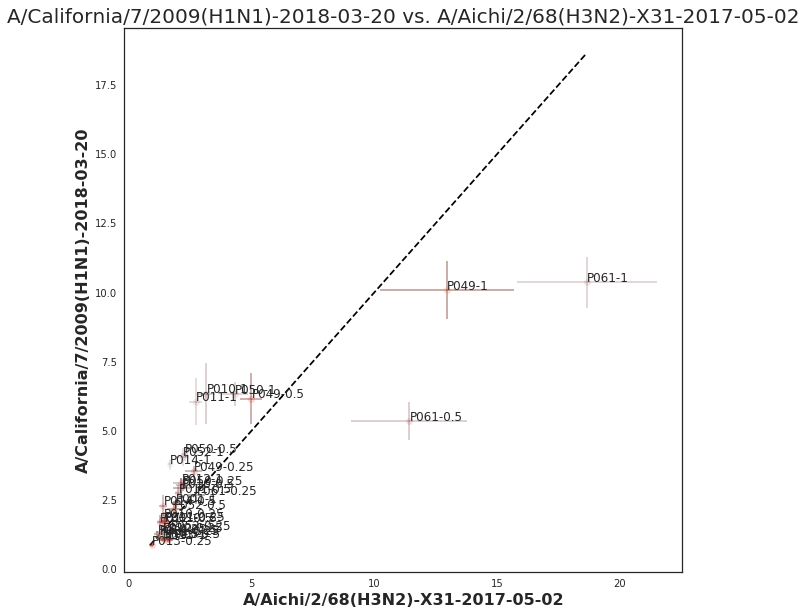

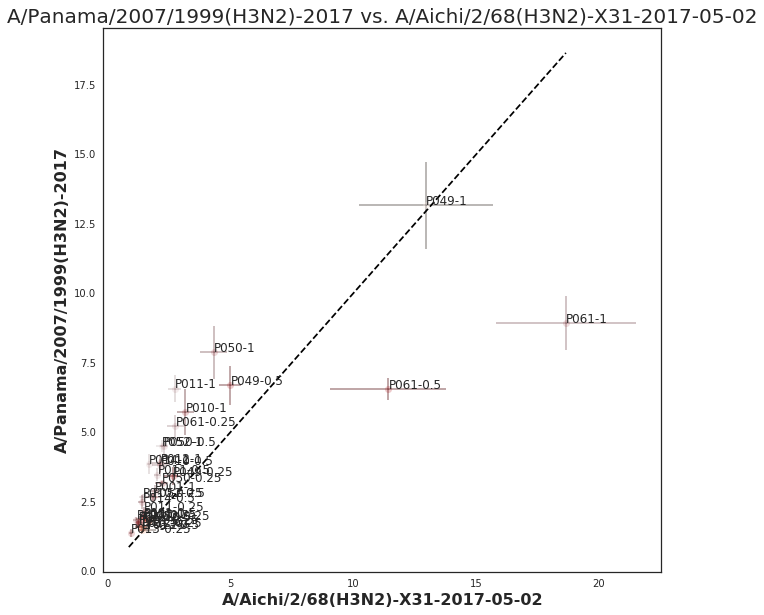

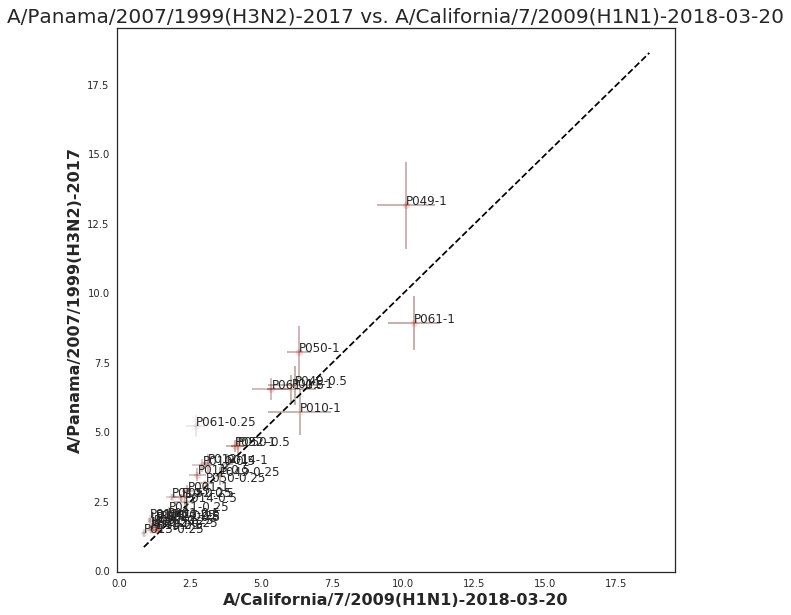

In [580]:
#fig, axes = plt.subplots(ncols=5,nrows=2, figsize = (25,10), sharey=True)

#ax_it = iter(axes.flatten())
peptide_c_signif.dropna(inplace=True)
cmap = cm.Reds
for name, d in peptide_c_signif.groupby("Analyte Batches"):
    x = y = np.linspace(peptide_c_signif.V1_I.min(),peptide_c_signif.V1_I.max())
    #ax = next(ax_it)
    fig, ax = plt.subplots(1,1,figsize=(10,10))

    ax.plot(x,y,linestyle="--",marker=" ", c="k", alpha=1)
    ax.set_title("{} vs. {}".format(name[1],name[0]), size = 20)
    ax.set_xlabel(name[0], size = 16, weight = 'bold')
    ax.set_ylabel(name[1], size = 16, weight = 'bold')
    #ax.set_xlim(0,x.max())
    #ax.set_ylim(0,y.max())

    
    #ax.set_xscale("log")
    #ax.set_yscale("log")



    #norm = Normalize(d.Significance.min(),d.Significance.max())
    d.sort_values("Significance",ascending=False, inplace=True)
    boundary = 0.15
    #d_selected = d[d["Significance"] < boundary]
    #d_n = d[d["Significance"] > boundary]
    
    #d_selected = d.loc[d["Ligand Batch"].isin(["P095","P059","P094","Nenad","P102"])]
    d_selected = d


    d_n = d
    #d_selected = d.loc[d["Peptide"].isin(["Pep_80","Pep_43","Pep_55","Pep_56","Pep_59","Pep_61","Pep_63","Pep_83","Pep_94","Pep_95","Pep_98","Pep_100","Pep_102","Pep_103","Pep_121" ,"Pep_125","Pep_131.2","Nenad","Pep_49","Pep_50"])]
    #d_selected = d.loc[d["Ligand Batch"].isin(["Nenad"])]
    #d_selected = d.loc[d["Peptide"].isin(["Pep_43","Pep_55","Pep_56","Pep_59","Pep_63","Pep_131.2"])]


    

    alphas = iter(np.linspace(0.3,0.05,len(d)))    

    for ii, dp in d_selected.iterrows():
        #if dp.Significance is not np.NaN:
            c = cmap(1-dp.Significance**(1/6))
            ax.errorbar(x=dp.V1_I,y=dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, c = c, fmt="o",linestyle="",alpha=next(alphas), capthick=2)
            ax.annotate(dp["Ligand Batch"],(dp.V1_I+0.01,dp.V2_I+0.01), size=12)
    alphas = iter(np.linspace(0.3,0.05,len(d)))    

    for ii, dp in d_n.iterrows():
        c = cmap(dp.Significance)
        ax.errorbar(x=dp.V1_I,y=dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, c = "k", fmt="o",linestyle="",alpha=next(alphas), ms = 0.5, capthick=1)
        
    #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    uri_name1 = name[0].replace("/","-")
    uri_name2 = name[1].replace("/","-")
    #plt.savefig(uri_name1+uri_name2+"correlations.png", bbox_inches="tight")   
    plt.show()


#plt.savefig(directory+"all_correlations.png", bbox_inches="tight")    
plt.show()    

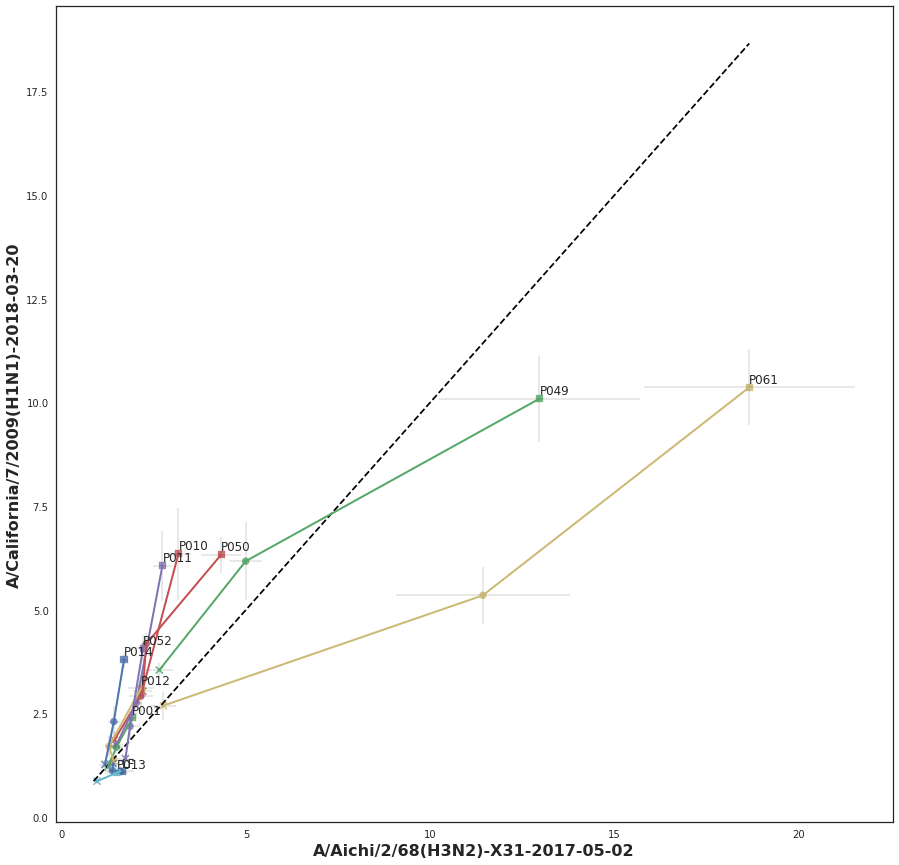

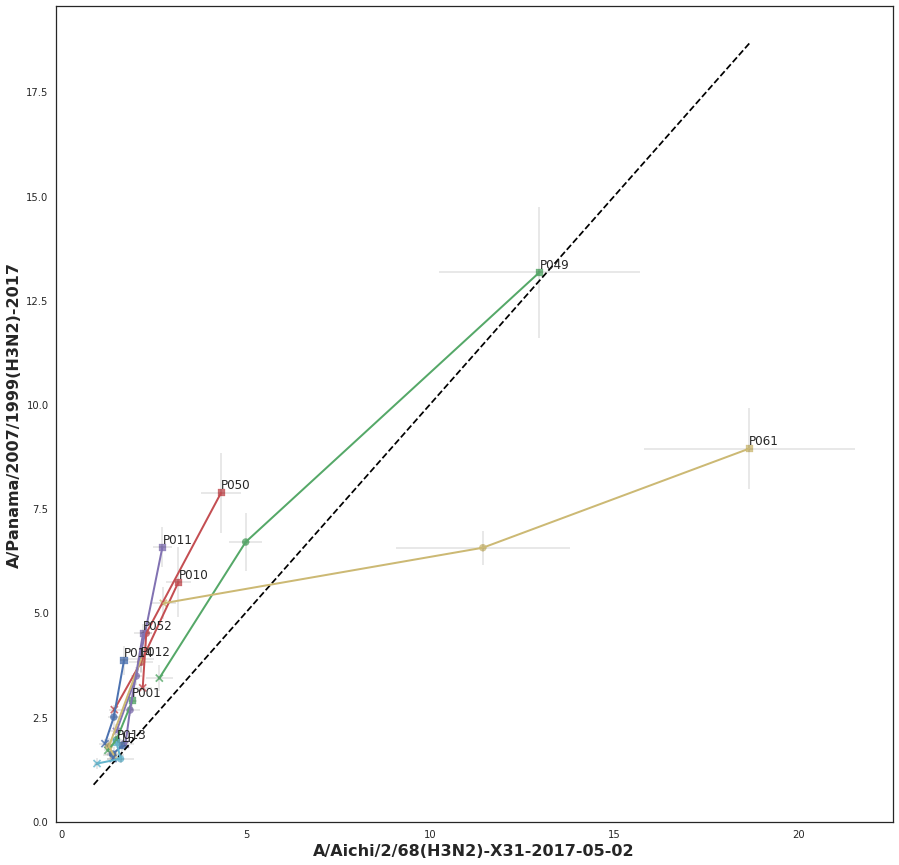

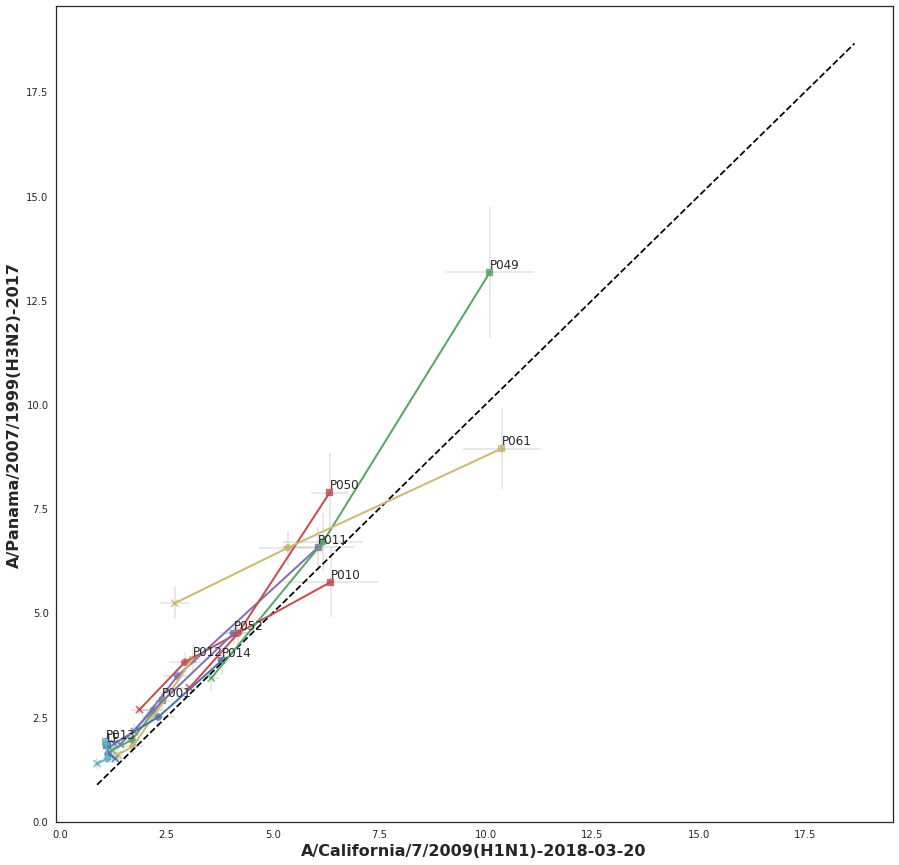

In [546]:
#fig, axes = plt.subplots(ncols=5,nrows=2, figsize = (25,10), sharey=True)
#ax_it = iter(axes.flatten())
peptide_c_signif.dropna(inplace=True)
cmap = cm.viridis
#mask = peptide_c_signif["Ligand"].isin(['P013','P001',"P012","LF"])
p_selected = peptide_c_signif#[~mask]
for name, d in p_selected.groupby("Analyte Batches"):
    markers = iter(["x","o","s"])

    x = y = np.linspace(p_selected.V1_I.min(),p_selected.V1_I.max())
    #ax = next(ax_it)
    fig, ax = plt.subplots(1,1,figsize=(15,15))

    ax.plot(x,y,linestyle="--",marker=" ", c="k", alpha=1)
    #ax.set_title("{} vs. {}".format(name[1],name[0]), size = 20)
    ax.set_xlabel(name[0], size = 16, weight = 'bold')
    ax.set_ylabel(name[1], size = 16, weight = 'bold')
    #ax.set_xlim(0,x.max())
    #ax.set_ylim(0,y.max())
    
    #ax.set_xscale("log")
    #ax.set_yscale("log")

    colors = []
    
    for name,dp in d.sort_values(by="Ligand").groupby("Ligand"):
        
        
    
        
        
        dp_sort1 = dp.sort_values(by="Ligand Batch Concentration")
        #display(dp_sort)
        #c = cmap(dp.Significance)
        #ax.errorbar(x=dp.V1_I,y=dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, c = "k", fmt="o",linestyle="--", ms = 0.5, capthick=1)
        #ax.annotate(dp["Ligand Batch"],(dp.V1_I+0.01,dp.V2_I+0.01), size=12)
        lines = ax.plot(dp_sort1.V1_I,dp_sort1.V2_I, label=name,alpha=1.0,linewidth=2.0,linestyle="-")
        colors.append(lines[0].get_color())
       
        

        
    for concentration ,dp in d.groupby("Ligand Batch Concentration"):
        dp_sort = dp.sort_values(by="Ligand")

        ax.errorbar(x=dp.V1_I,y = dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, marker="", c="k", linestyle="",alpha=0.1)
        
    
        ax.scatter(x=dp_sort.V1_I,y = dp_sort.V2_I,marker=next(markers), c=colors, alpha=0.8,s=50)
        
        if concentration == 1.0:
            for i,n in enumerate(dp):
                ax.annotate(dp["Ligand"].iloc[i],(dp.V1_I.iloc[i]+0.0,dp.V2_I.iloc[i]+0.1), size=12)
       


    
                             
    #leg = ax.legend() 
    #for line in leg.get_lines():
    #    line.set_linewidth(6.0)

    

    #alphas = iter(np.linspace(0.3,0.05,len(d)))
    

    #for ii, dp in d_selected.iterrows():
        #if dp.Significance is not np.NaN:
    #        c = cmap(dp.Significance)
    #        ax.errorbar(x=dp.V1_I,y=dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, c = c, fmt="o",linestyle="",alpha=0.8, capthick=2)
    #        ax.annotate(dp["Ligand Batch"],(dp.V1_I+0.01,dp.V2_I+0.01), size=12)
    
    #for ii, dp in d_n.iterrows():
    #    c = cmap(dp.Significance)
    #    ax.errorbar(x=dp.V1_I,y=dp.V2_I,xerr=dp.V1_Err,yerr=dp.V2_Err, c = "k", fmt="o",linestyle="",alpha=next(alphas), ms = 0.5, capthick=1)
        
    #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #uri_name1 = name[0].replace("/","-")
    #uri_name2 = name[1].replace("/","-")
    #plt.savefig(uri_name1+uri_name2+"correlations.png", bbox_inches="tight")
    #plt.savefig("all_correlations.svg", bbox_inches="tight")    

    plt.show()


#plt.show()    

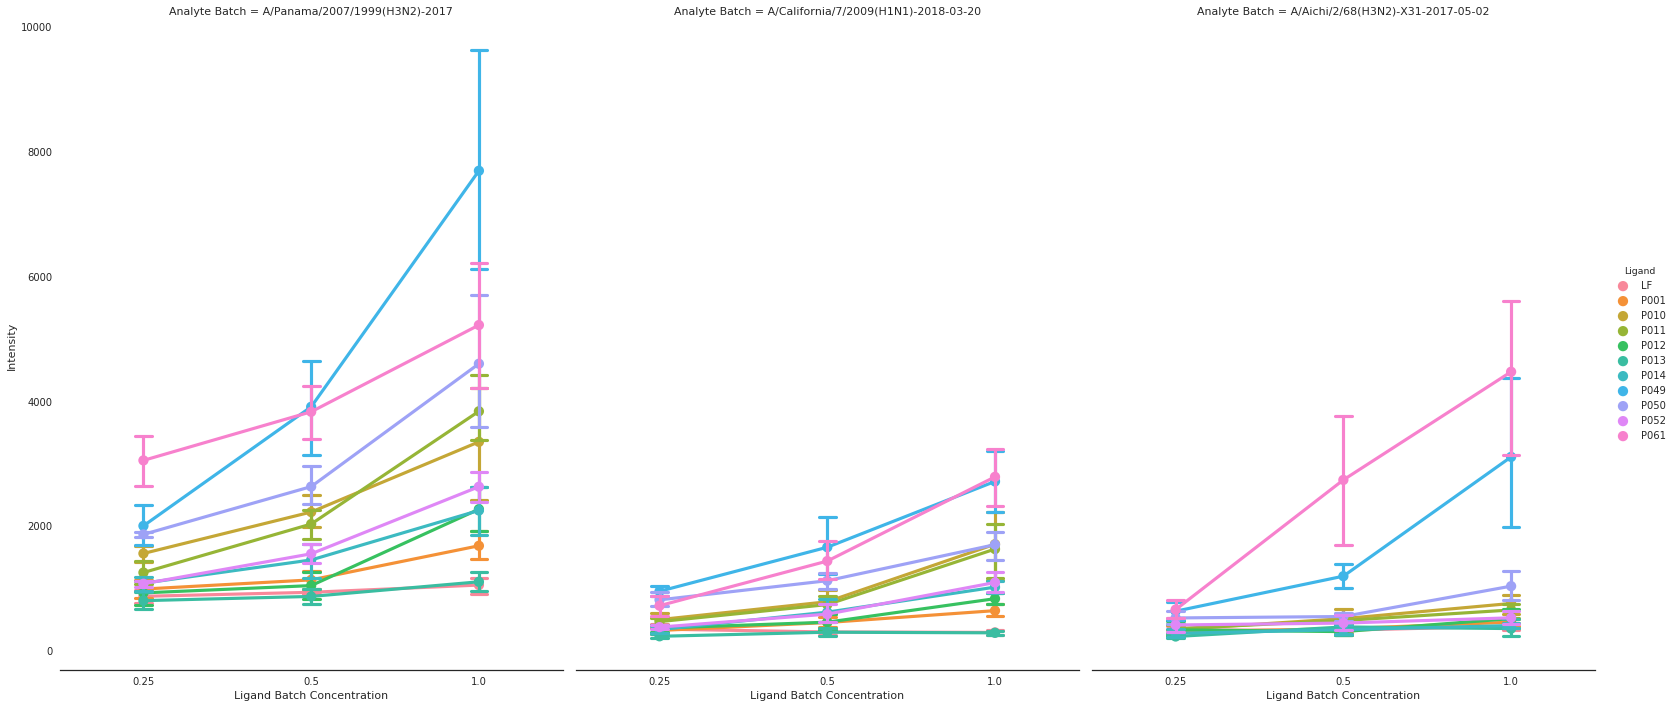

In [547]:
import seaborn as sns

sns.set(style="white")
g = sns.factorplot(x="Ligand Batch Concentration", y="Intensity", hue="Ligand", col="Analyte Batch", data=data.spots_pd,
                   capsize=.1,  size=10, aspect=.75)
g.despine(left=True)
plt.show()